In [1]:
import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [4]:
## find signal with high seizure vote
metadata[metadata['expert_consensus'] == 'Seizure']

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
5,2161044411,3,22.0,983335548,3,22.0,3235853606,39251,Seizure,3,0,0,0,0,0
6,740996715,5,40.0,1428271696,5,40.0,2393090400,7283,Seizure,3,0,0,0,0,0
10,2655435410,10,82.0,1868716316,10,82.0,2064713930,24305,Seizure,3,0,0,0,0,0
20,924871605,21,108.0,707210069,21,108.0,4108410483,3596,Seizure,3,0,0,0,0,0
25,1735082541,8,42.0,26635579,8,42.0,4077460480,26091,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,3883443135,3,16.0,1783124126,3,16.0,2389716725,35946,Seizure,3,0,0,0,0,0
978,1735082541,1,6.0,26635579,1,6.0,2256315638,26091,Seizure,3,0,0,0,0,0
980,2842525354,14,140.0,215559912,14,140.0,540584599,10475,Seizure,3,0,0,0,0,0
983,1057856283,1,40.0,1506263931,1,40.0,3244710151,61701,Seizure,3,0,0,0,0,0


In [6]:
# Load into Dask
import dask.dataframe as dd
import numpy as np
import glob

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
            ]
sfreq = 200
eeg_ids = metadata['eeg_id'].to_list()

ddf_list = []
for eeg_id in eeg_ids:
  f_name = f'data/eeg/{eeg_id}.parquet'
  temp_ddf = dd.read_parquet(f_name).drop('EKG', axis=1)[channel_order]
  temp_ddf['eeg_id'] = str(eeg_id)
  temp_ddf = temp_ddf.set_index('eeg_id')
  ddf_list.append(temp_ddf)

ddf = dd.concat(ddf_list)
ddf



<<<<<<< local


<<<<<<< local <modified: text/html, text/plain>


,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
npartitions=1000,,,,,,,,,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


>>>>>>> remote <removed>


,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
npartitions=1000,,,,,,,,,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


>>>>>>> remote


<span style="color:red"><b><<<<<<< local</b></span>

In [6]:
sig1 = ddf.loc['2161044411'].compute()
sig1

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
eeg_id,,,,,,,,,,,,,,,,,,,
2161044411,-4.990000,1.080000,36.369999,38.619999,20.420000,12.780000,-7.110000,26.900000,16.740000,12.02,-10.150000,30.350000,19.709999,-45.099998,0.530000,-4.360000,-16.740000,-25.250000,-11.820000
2161044411,-8.370000,-8.270000,34.750000,26.770000,9.920000,-2.990000,-14.990000,-14.420000,1.290000,-0.29,-25.510000,22.200001,-0.790000,-56.259998,-10.000000,-13.280000,-23.160000,-32.880001,-18.370001
2161044411,-21.330000,-16.969999,11.280000,17.570000,-1.770000,-13.180000,-21.129999,13.460000,-11.670000,-10.41,-32.599998,15.000000,-11.220000,-64.160004,-17.889999,-20.670000,-28.570000,-39.419998,-25.190001
2161044411,-24.629999,-15.810000,14.430000,3.310000,-2.780000,-11.130000,-20.280001,46.669998,-34.200001,-10.58,-31.580000,16.480000,-16.330000,-67.500000,-18.520000,-19.030001,-26.760000,-38.450001,-24.690001
2161044411,-11.920000,-16.430000,53.830002,14.350000,1.120000,-12.720000,-25.570000,43.470001,-37.750000,-9.70,-34.330002,12.290000,-14.730000,-69.379997,-18.480000,-22.090000,-29.139999,-42.130001,-25.360001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161044411,4.140000,66.199997,49.080002,38.450001,19.770000,49.560001,14.240000,110.129997,21.420000,7.18,-19.959999,82.129997,118.800003,-7.350000,13.990000,-4.540000,-27.879999,-35.990002,-18.440001
2161044411,-2.330000,25.850000,31.440001,9.480000,8.530000,16.730000,8.510000,84.879997,11.390000,-2.26,-17.290001,79.260002,103.970001,-18.889999,8.190000,1.130000,-4.010000,-46.700001,-16.150000
2161044411,12.400000,49.529999,46.630001,16.400000,17.370001,42.180000,24.100000,86.029999,28.450001,9.74,-13.860000,93.599998,108.610001,-10.400000,17.160000,8.990000,3.950000,-41.369999,-5.970000


In [7]:
## MNE setup
import mne

mne_info = mne.create_info(ch_names=sig1.columns.tolist(), sfreq=200, ch_types='eeg')
mne_info.set_montage('standard_1020')
    
sig1_data = np.array(sig1.transpose())
sig1_data = np.nan_to_num(sig1_data)
    
raw = mne.io.RawArray(sig1_data, mne_info)
raw.apply_function(lambda x: x / 20e6, picks='eeg')

Creating RawArray with float64 data, n_channels=19, n_times=14800
    Range : 0 ... 14799 =      0.000 ...    73.995 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


Using matplotlib as 2D backend.


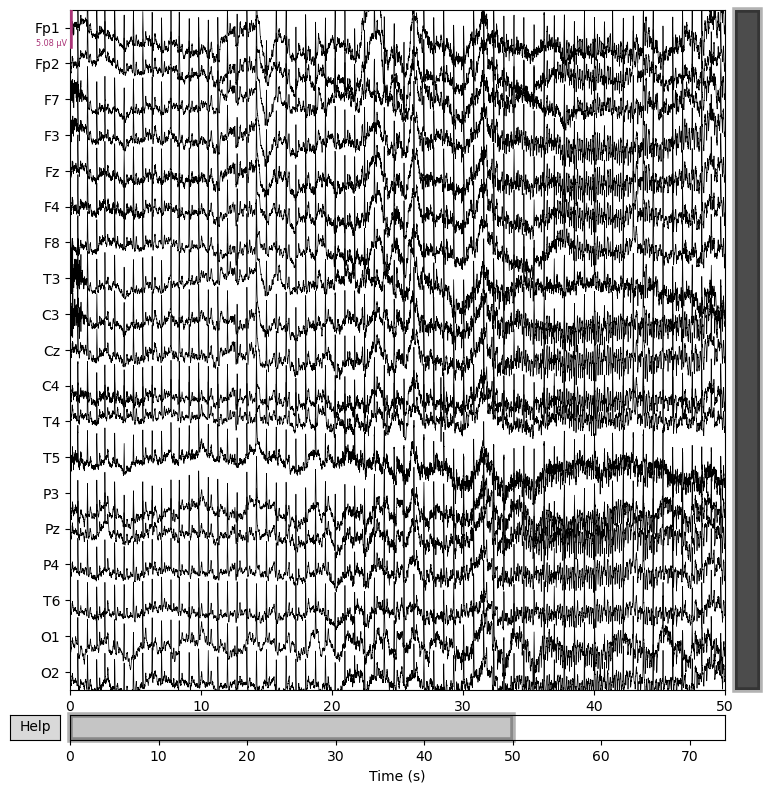

In [8]:
raw.plot(duration=50, proj=False, scalings={'eeg': 'auto'}, n_channels=len(raw.ch_names), remove_dc=False);

# Preprocessing
We must implement preprocessing techniques in order to remove artifacts

## Power Line Artifacts
The power line artifact occurs at 60Hz and can be seen in the plot below. To remove this, we can apply a notch filter

In [9]:
import matplotlib.pyplot as plt
#raw.plot(duration=50, n_channels=19, proj=False, remove_dc=False);
def add_arrows(axes):
  for ax in axes:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    freq = 60
    idx = np.searchsorted(freqs, freq)
    y = psds[(idx-4) : (idx+5)].max()
    ax.arrow(
      x=freqs[idx],
      y=y + 18,
      dx=0,
      dy=-12,
      color="red",
      width=0.1,
      head_width=3,
      length_includes_head=True,
    )

psd = raw.compute_psd();
fig = psd.plot(average=True, picks="data", exclude="bads");
add_arrows(fig.axes[:2]);


Effective window size : 10.240 (s)


/Users/gagetylee/anaconda3/envs/340-project/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 661 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


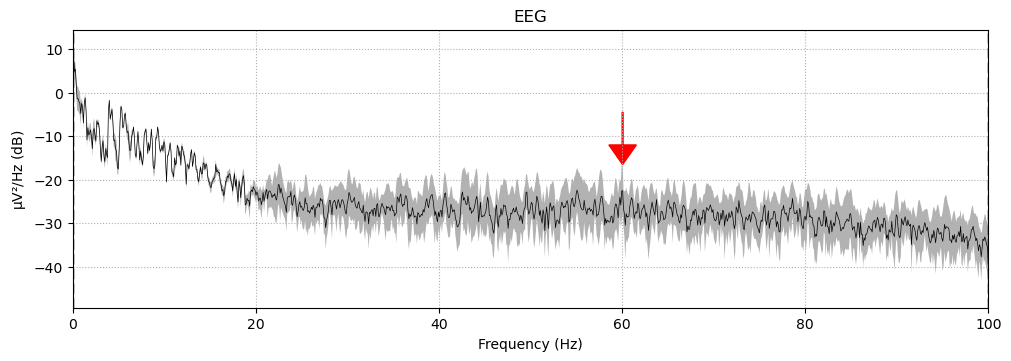

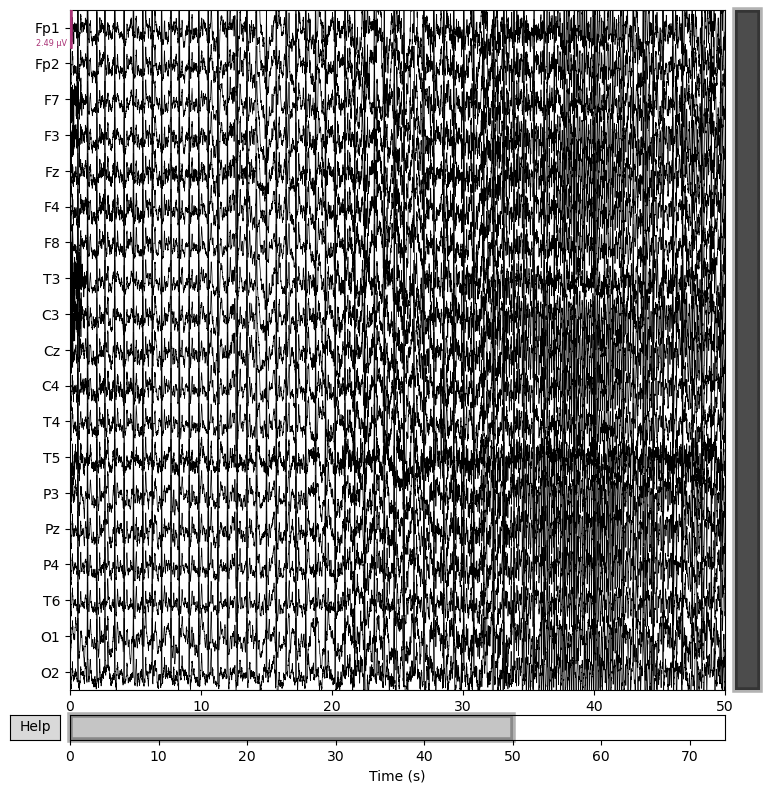

In [10]:
# Apply filter
from src.preprocessing import notch_filter

l_freq = 1.0
h_freq = 70.0

raw = raw.filter(l_freq, h_freq, method='fir')
raw_notch = notch_filter(raw, 60);
raw.plot(start=0, duration=50, proj=False, scalings={'eeg': 'auto'}, n_channels=len(raw.ch_names), remove_dc=False);

In [11]:
# Standardize signal
from src.preprocessing import standardize

sig_standard = standardize(sig1)
sig_standard

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
eeg_id,,,,,,,,,,,,,,,,,,,
2161044411,-0.454124,-0.170729,1.476879,1.581926,0.732210,0.375516,-0.553102,1.034746,0.560400,0.340034,-0.695032,1.195819,0.699062,-2.326766,-0.196408,-0.424710,-1.002704,-1.400016,-0.773000
2161044411,-0.061801,-0.056984,2.014983,1.630643,0.819099,0.197316,-0.380639,-0.353186,0.403453,0.327356,-0.887313,1.410539,0.303274,-2.368321,-0.140306,-0.298280,-0.774130,-1.242273,-0.543430
2161044411,-0.336709,-0.116037,1.313779,1.632134,0.653280,0.075786,-0.326587,1.424115,0.152212,0.215984,-0.907117,1.502059,0.174988,-2.504462,-0.162601,-0.303305,-0.703147,-1.252297,-0.532075
2161044411,-0.417507,-0.042536,1.243077,0.770325,0.511417,0.156428,-0.232572,2.613718,-0.824363,0.179810,-0.712977,1.330230,-0.064643,-2.240068,-0.157748,-0.179430,-0.508061,-1.005046,-0.420057
2161044411,0.034019,-0.126240,2.370389,0.967501,0.497384,0.005592,-0.451022,2.002255,-0.883827,0.112905,-0.762301,0.894301,-0.065832,-2.007772,-0.199085,-0.327363,-0.577878,-1.039467,-0.443560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161044411,-0.488145,0.942713,0.547994,0.302908,-0.127779,0.559061,-0.255279,1.955565,-0.089737,-0.418055,-1.043796,1.309996,2.155461,-0.753059,-0.261043,-0.688271,-1.226399,-1.413384,-1.008750
2161044411,-0.467317,0.300201,0.452452,-0.145657,-0.171531,0.051806,-0.172076,1.907957,-0.093635,-0.465410,-0.874771,1.754890,2.427898,-0.918349,-0.180791,-0.373079,-0.513074,-1.675790,-0.843722
2161044411,-0.365639,0.634389,0.556283,-0.257906,-0.231781,0.436430,-0.050521,1.617448,0.066638,-0.437281,-1.072903,1.821332,2.225598,-0.979714,-0.237437,-0.457481,-0.593224,-1.813833,-0.860400


<span style="color:red"><b>=======</b></span>

In [8]:
df = ddf.compute()
df



,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
eeg_id,,,,,,,,,,,,,,,,,,,
4144388963,4.340000,-30.620001,33.320000,14.510000,-27.790001,21.660000,-37.009998,11.040000,-7.910000,-19.620001,-7.380000,9.900000,5.670000,-9.180000,-0.63,9.350000,9.260000,-13.74,-7.970000
4144388963,1.900000,-28.379999,24.629999,2.340000,-28.870001,18.320000,-29.200001,21.520000,-12.530000,-18.240000,-3.400000,9.310000,7.950000,-7.210000,2.29,14.290000,12.010000,-11.14,-3.830000
4144388963,18.959999,-14.940000,51.020000,-7.860000,-28.110001,9.710000,-16.610001,37.540001,-17.780001,-19.290001,-14.670000,14.190000,9.460000,-8.130000,-0.56,8.720000,9.810000,-8.72,-6.950000
4144388963,23.230000,-13.990000,45.340000,11.850000,-25.930000,0.320000,1.800000,36.529999,-7.400000,-19.320000,-26.650000,2.440000,7.960000,-6.550000,-0.41,4.450000,5.170000,-6.82,-5.790000
4144388963,3.680000,-24.469999,23.020000,12.820000,-26.860001,21.740000,-0.360000,-8.000000,-4.640000,-18.670000,-16.360001,53.560001,6.290000,-7.360000,0.08,8.530000,10.930000,-10.94,-5.860000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735834491,-39.990002,-11.380000,14.590000,-20.500000,-15.240000,-23.340000,-57.529999,-12.530000,7.420000,-20.930000,-16.010000,1.680000,-3.070000,-1.150000,2.43,-0.170000,-23.500000,-6.85,3.350000
735834491,-74.470001,-50.410000,-10.230000,-46.110001,-35.630001,-53.380001,-85.099998,-32.070000,-14.630000,-38.250000,-40.669998,-25.490000,-22.780001,-22.990000,-15.43,-26.559999,-49.869999,-26.16,-22.389999
735834491,-66.209999,-31.180000,-4.690000,-39.560001,-26.389999,-49.680000,-75.089996,-27.030001,-7.510000,-28.959999,-32.930000,-10.000000,-10.790000,-11.880000,-5.56,-20.100000,-42.110001,-11.15,-14.310000


In [9]:
print(np.var(df['Fp1'], axis=0)) #variance for one col/channel
fpl = df['Pz'].fillna(0).to_numpy() #converting to numby array for easier computation
print(np.var(fpl, axis=0))

718546.75
337383.94


In [10]:
# one sample and their channels
sig1 = df.loc[['1618328341']]
sig1

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
eeg_id,,,,,,,,,,,,,,,,,,,
1618328341,34.400002,86.589996,-40.759998,-19.090000,-2.850000,30.740000,27.959999,-37.130001,-46.180000,-16.33,-2.29,18.639999,-52.200001,-48.480000,-21.540001,-33.259998,-33.840000,-47.520000,-50.599998
1618328341,35.689999,92.430000,-29.830000,-11.670000,5.910000,38.959999,31.400000,-29.719999,-39.029999,-7.53,8.05,29.690001,-39.060001,-43.009998,-14.730000,-13.180000,-4.350000,-43.599998,-37.070000
1618328341,31.950001,91.120003,-25.870001,-11.580000,3.510000,41.389999,29.580000,-22.469999,-36.720001,-1.94,16.57,19.430000,-28.420000,-35.759998,-3.830000,2.600000,6.930000,-32.689999,-21.850000
1618328341,26.730000,71.000000,-26.219999,-17.850000,-11.600000,26.040001,3.490000,-17.559999,-39.130001,-6.43,9.83,-1.340000,-26.280001,-29.180000,9.220000,8.160000,17.080000,-18.879999,-10.840000
1618328341,24.799999,65.709999,-26.160000,-16.400000,-7.720000,24.540001,-6.660000,-21.770000,-37.270000,-1.79,11.62,-0.550000,-22.400000,-21.969999,15.090000,17.719999,16.299999,-8.130000,1.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618328341,-123.110001,-79.769997,-57.580002,-49.369999,-37.799999,0.600000,32.070000,25.440001,-6.710000,-0.58,20.99,61.919998,41.880001,14.470000,14.070000,22.209999,35.299999,33.040001,7.410000
1618328341,-136.369995,-99.459999,-59.759998,-57.430000,-50.759998,-7.860000,22.990000,39.930000,-5.810000,-6.99,13.51,53.189999,49.139999,21.200001,20.990000,21.350000,38.080002,40.400002,11.210000
1618328341,-136.460007,-99.830002,-49.590000,-50.619999,-43.549999,-6.320000,21.549999,43.349998,3.680000,-2.75,17.32,46.320000,62.189999,28.340000,24.750000,26.459999,51.869999,43.480000,13.330000


In [11]:
sig1['Fp1']


eeg_id
1618328341     34.400002
1618328341     35.689999
1618328341     31.950001
1618328341     26.730000
1618328341     24.799999
                 ...    
1618328341   -123.110001
1618328341   -136.369995
1618328341   -136.460007
1618328341   -139.380005
1618328341   -151.929993
Name: Fp1, Length: 22800, dtype: float32

In [12]:
# variance for one channel(Fp1) in one signal(4144388963)
np.var(sig1['Fp1'].to_numpy())


4566.286

In [15]:
from feature_extraction.channel_selection import calculate_top_channels

top_channels = calculate_top_channels(sig1)
print("Top 3 channels with highest variance for the single sample:")
for i, channel in enumerate(top_channels, start=1):
    print(f"{i}. {channel}")

All channels: [('Fp2', 6680.8887), ('Fp1', 4566.286), ('F7', 2778.6633), ('T3', 2048.039), ('F8', 1655.0438), ('T5', 1345.5327), ('O1', 1132.6462), ('T6', 1045.611), ('T4', 1009.99817), ('O2', 1004.8821), ('P3', 904.27844), ('P4', 758.57056), ('Pz', 616.15546), ('C3', 592.70886), ('F4', 521.0158), ('F3', 478.9111), ('C4', 429.0064), ('Fz', 402.60165), ('Cz', 130.08998)]
Top 3 channels with highest variance for the single sample:
1. Fp2
2. Fp1
3. F7


<span style="color:red"><b><<<<<<< local</b></span>

<span style="color:red"><b>>>>>>>> remote</b></span>

<span style="color:red"><b>=======</b></span>

In [24]:
import numpy as np

channels_lists= ['Fp2', 'Fp1', 'F7']

# a dictionary to store the std values
channel_std_sig1 = {}

# Loop through the channels of interest, calculate std, and store in the dictionary
for channel in channels_lists:
    channel_data = sig1[channel].values
    # calculate std value using nanmean
    std_value = np.nanstd(channel_data)
    channel_std_sig1[channel] = std_value

# Display the calculated std values for sig1
print("STD values for the sample '1618328341':")
for channel, std in channel_std_sig1.items():
    print(f"{channel}: {std}")


STD values for the sample '1618328341':
Fp2: 81.73670196533203
Fp1: 67.57430267333984
F7: 52.71302795410156


In [20]:
import numpy as np

channels_lists= ['Fp2', 'Fp1', 'F7']

# a dictionary to store the mean values
channel_means_sig1 = {}

# Loop through the channels of interest, calculate mean, and store in the dictionary
for channel in channels_lists:
    channel_data = sig1[channel].values
    # calculate mean value using nanmean
    mean_value = np.nanmean(channel_data)
    channel_means_sig1[channel] = mean_value

# Display the calculated mean values for sig1
print("Mean values for the sample '1618328341':")
for channel, mean in channel_means_sig1.items():
    print(f"{channel}: {mean}")


Mean values for the sample '1618328341':
Fp2: -4.259478569030762
Fp1: -13.535626411437988
F7: -20.5283203125


In [22]:
import numpy as np


channels_of_interest = ['Fp2', 'Fp1', 'F7']

# a dictionary to store the maximum values
channel_max_values_sig1 = {}

# Loop through the channels of interest, calculate max, and store in the dictionary
for channel in channels_of_interest:
    # calculate max value using nanmean
    channel_data = sig1[channel].values
    max_value = np.nanmax(channel_data)
    channel_max_values_sig1[channel] = max_value

# Display the calculated max values for sig1
print("Maximum values for the sample '1618328341':")
for channel, max_val in channel_max_values_sig1.items():
    print(f"{channel}: {max_val}")


Maximum values for the sample '1618328341':
Fp2: 277.1199951171875
Fp1: 152.2899932861328
F7: 234.50999450683594


In [23]:
import numpy as np


channels_of_interest = ['Fp2', 'Fp1', 'F7']

# a dictionary to store the minimum values
channel_min_values_sig1 = {}

# Loop through the channels of interest, calculate min, and store in the dictionary
for channel in channels_of_interest:
    # calculate min value using nanmean
    channel_data = sig1[channel].values
    min_value = np.nanmin(channel_data)
    channel_min_values_sig1[channel] = min_value

# Display the calculated min values for sig1
print("Maximum values for the sample '1618328341':")
for channel, min_val in channel_min_values_sig1.items():
    print(f"{channel}: {min_val}")


Maximum values for the sample '1618328341':
Fp2: -472.5899963378906
Fp1: -409.8800048828125
F7: -247.69000244140625


<span style="color:red"><b>>>>>>>> remote</b></span>

Creating RawArray with float64 data, n_channels=19, n_times=22800
    Range : 0 ... 22799 =      0.000 ...   113.995 secs
Ready.
Using matplotlib as 2D backend.


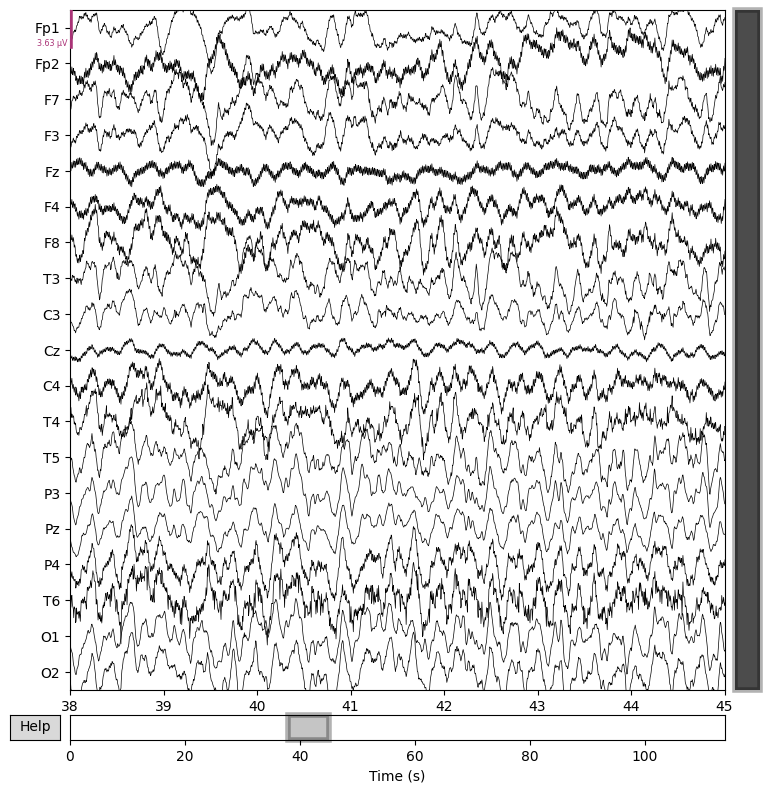

Applying baseline correction (mode: mean)


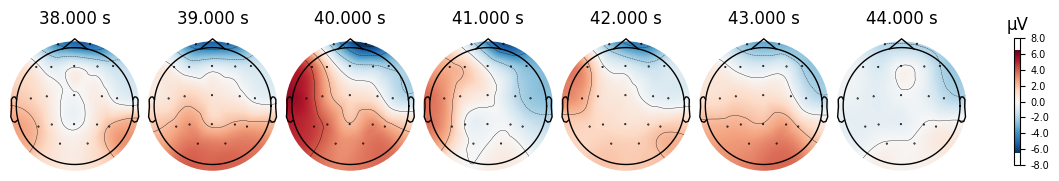

In [14]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
# Visualization
from visualize import VisualizeEEG
raw_df = ddf.partitions[2].compute()

vis_eeg = VisualizeEEG(raw_df)
# Plot signal channels
vis_eeg.plot_signal(start=38, duration=7)
# Plot topographic map
vis_eeg.plot_topomap(start=38, end=45, delta=1)

